In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
plt.rcParams["figure.figsize"] = (15,10)
import os 

In [5]:
os.chdir('/Users/tatum/Documents/dsc180b/charlie-data')

In [8]:
train_data=['40_40_5000_a.csv', '40_40_5000_b.csv', '40_40_5000_c.csv','40_40_5000_d.csv', '40_40_5000_e.csv','40_40_5000_m.csv','40_5000_160_1250_a.csv', '40_40_5000_f.csv', '40_40_5000_g.csv', '40_5000_160_1250_b.csv','40_40_5000_h.csv', '40_40_5000_i.csv', '40_5000_160_1250_c.csv', '40_40_5000_j.csv', '40_5000_160_1250_d.csv','40_40_5000_k.csv','40_40_5000_l.csv', '40_5000_160_1250_e.csv']
test_data = ['40_40_5000_n.csv','40_40_5000_o.csv','40_5000_320_1250_b.csv','40_40_5000_p.csv','40_40_5000_q.csv','40_40_5000_r.csv','40_5000_320_500_a.csv',
            '40_40_5000_s.csv','40_5000_320_1250_c.csv', '40_5000_320_1250_a.csv','40_5000_320_500_b.csv','40_5000_320_500_c.csv']
             
def aggregate_data(data, n):
    df = pd.DataFrame(pd.read_csv(data[0])[20:].reset_index().drop('index',axis=1))
    df['total_pkts'] = df['1->2Pkts'] + df['2->1Pkts']
    df = df[df['total_pkts'] >1].reset_index().drop('index',axis=1)
    df['anom'] = 0
    df.loc[160:,'anom'] = 1
    for file in data[1:]:
        dff = pd.DataFrame(pd.read_csv(file)[20:]).reset_index().drop('index',axis=1)
        dff['total_pkts'] = dff['1->2Pkts'] +df['2->1Pkts']
        dff = dff[dff.total_pkts > 1].reset_index().drop('index',axis=1)
        dff['anom'] = 0
        dff.loc[160:,'anom'] = 1
        df=  pd.concat([df,dff],ignore_index=True)
    df = df[:len(df) - (len(df) %n)]
    df_agg = pd.DataFrame([df[:n]['total_pkts'].mean(), df[:n]['anom'].max()],index=['total_pkts','anom']).T
    for i in range(n,df.shape[0],n):
        df_agg = pd.concat([df_agg,pd.DataFrame([df[i:i+n]['total_pkts'].mean(),df[i:i+n]['anom'].max()],index=['total_pkts','anom']).T],ignore_index=True)
    return df_agg,df
DF,df = aggregate_data(train_data,20)
test_df,dff = aggregate_data(test_data,20)

In [13]:
def eval_arima(X,arima_order,conf,n):
    train, test = X[:n], X[n:]
    history = [x for x in train]
    predictions = list()
    anomalies=[]
    upperLim=[]
    lowerLim=[]
    for t in range(n,len(test)+n):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(method_kwargs={"warn_convergence": False})
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        result = model_fit.get_forecast()
        conf_int = result.conf_int(alpha=conf)
        upperLim.append(conf_int[0,1])
        lowerLim.append(conf_int[0,0])
        if obs >= conf_int[0,0] and obs <= conf_int[0,1]:
            anomalies.append(0)
        else:
            anomalies.append(1)
    rmse = mean_squared_error(test, predictions, squared=False)
    return model_fit.aic,model_fit,test,predictions,anomalies,upperLim,lowerLim

In [14]:
rmse, model, test, preds,anomalies,upper,lower= eval_arima(np.log(DF.total_pkts), (3,0,2),.01,75)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [104]:
len(DF.total_pkts[75:])

186

In [101]:
len(anomalies)

186

In [98]:
anomalies[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from sklearn.cluster import DBSCAN, MeanShift
import scipy.stats as stats
from collections import Counter
import scipy

from os.path import isfile, join, expanduser
from os import listdir, remove
from numpy.fft import fft, ifft, fft2, ifft2, fftshift

In [52]:
raw_data_path = '../loss_logs'
raw_files_loss = [join(raw_data_path, f) for f in listdir(raw_data_path)]
raw_files_loss[:4]

['../loss_logs/losslog-50-2500-true-200-500.csv',
 '../loss_logs/losslog-50-5000-true-150-1500.csv',
 '../loss_logs/losslog-50-2500-true-250-1000.csv',
 '../loss_logs/losslog-50-25000-true-50-5000.csv']

In [53]:
raw_data_path = '../not_loss_logs'
raw_files = [join(raw_data_path, f) for f in listdir(raw_data_path)]
raw_files[:4]

['../not_loss_logs/20220111T002528_50-25000-true-250-25000-iperf.csv',
 '../not_loss_logs/20220119T053056_50-2500-true-250-500-iperf.csv',
 '../not_loss_logs/20220119T025048_50-5000-true-200-1000-iperf.csv',
 '../not_loss_logs/20220119T044648_50-5000-true-200-2500-iperf.csv']

In [61]:
metrics = []
losslog = []
filenames = {}
for file in raw_files:
    labels = file.split('_')[-1].split('-')
    print(labels)
    metrics = metrics + [labels[0] +' '+ labels[1] +' '+ labels[3]+' '+labels[4]+' '+labels[2]]
    filenames[labels[0] +' '+ labels[1] +' '+ labels[3]+' '+labels[4]+' '+labels[2]] = [file]
    
for file in raw_files_loss:
    labels = file.split('.')[-2].split('-')
    filenames[labels[1] +' '+ labels[2] +' '+ labels[4]+' '+labels[5]+' '+labels[3]] += [file]

['50', '25000', 'true', '250', '25000', 'iperf.csv']
['50', '2500', 'true', '250', '500', 'iperf.csv']
['50', '5000', 'true', '200', '1000', 'iperf.csv']
['50', '5000', 'true', '200', '2500', 'iperf.csv']
['50', '25000', 'false', '50', '5000', 'iperf.csv']
['50', '5000', 'true', '250', '1500', 'iperf.csv']
['50', '5000', 'true', '100', '2500', 'iperf.csv']
['50', '5000', 'true', '300', '2000', 'iperf.csv']
['50', '2500', 'true', '50', '1250', 'iperf.csv']
['50', '5000', 'true', '100', '2000', 'iperf.csv']
['50', '5000', 'true', '100', '1500', 'iperf.csv']
['50', '2500', 'true', '300', '1250', 'iperf.csv']
['50', '2500', 'true', '50', '1000', 'iperf.csv']
['50', '2500', 'true', '100', '1250', 'iperf.csv']
['50', '2500', 'true', '200', '1000', 'iperf.csv']
['50', '2500', 'true', '200', '1250', 'iperf.csv']
['50', '2500', 'true', '50', '500', 'iperf.csv']
['50', '5000', 'true', '50', '2500', 'iperf.csv']
['50', '2500', 'true', '300', '500', 'iperf.csv']
['50', '5000', 'true', '100', '1000

In [64]:
f = filenames['50 5000 50 1000 true'][1]
data_drop = pd.read_csv(f, header=None)
data_drop.columns = ['drop', 'Time', 'IP1', 'Port1', 'IP2', 'Port2', '?']
data_drop.head()

,drop,Time,IP1,Port1,IP2,Port2,?
0,drop,1.642560e+09,172.20.0.2,5001,172.21.0.3,38844,6
1,drop,1.642560e+09,172.21.0.3,38844,172.20.0.2,5001,6
2,drop,1.642560e+09,172.21.0.3,38844,172.20.0.2,5001,6
3,drop,1.642560e+09,172.20.0.2,5001,172.21.0.3,38844,6
4,drop,1.642560e+09,172.21.0.3,38844,172.20.0.2,5001,6


In [65]:
def clean_df(df):
    GROUP_INTERVAL = 10
    '''
    removes unnecessary connections from data and
    removes initial peak from dataset
    '''
    # df_cleaned = df[df['Proto'] == df['Proto'].mode()[0]]
    df_cleaned = df[df['IP1'] == df['IP1'].mode()[0]] 

    df_cleaned['group'] = df_cleaned['Time'].astype(int)//GROUP_INTERVAL # generates 10 second groupings of the data.
    
    timefilter = np.sort(df_cleaned['group'].unique())[3:] # takes out first thirty seconds from dataset
    #df_cleaned = df_cleaned[df_cleaned['group'].isin(timefilter)] # comment out to include initial peak
    df_cleaned.drop(columns='group', inplace=True)

    return df_cleaned

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Text(0.5, 0, 'time')

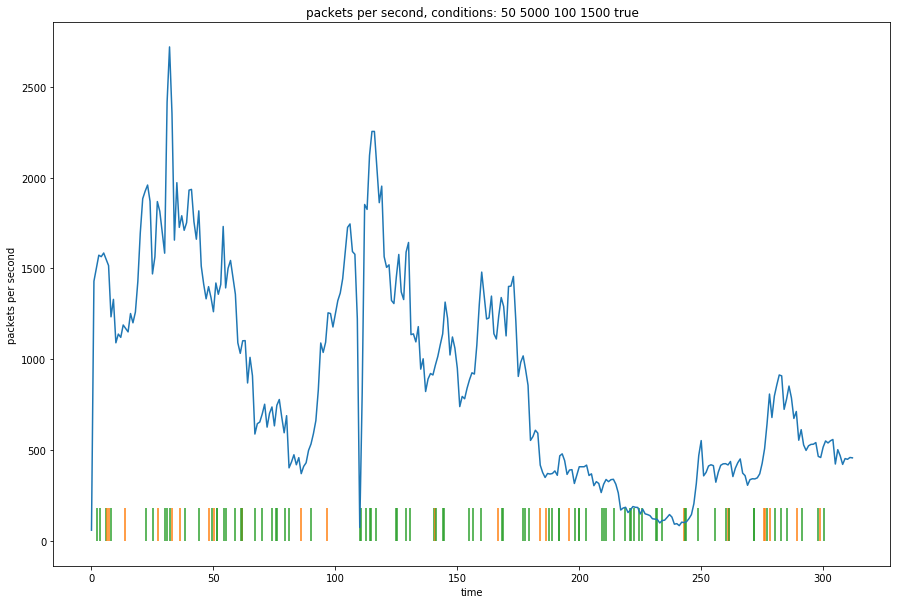

In [66]:
conditions = '50 5000 100 1500 true'
f = filenames[conditions][0]
f_drop = filenames[conditions][1]
data = pd.read_csv(f)
data_drop = pd.read_csv(f_drop, header=None)
data_drop.columns = ['drop', 'Time', 'IP1', 'Port1', 'IP2', 'Port2', '?']
clean = clean_df(data)
plt.plot(clean['1->2Pkts'])

port = data_drop['Port1']
time = data_drop['Time'] - data['Time'].min()
max_pkts = clean['1->2Pkts'].max()

for i in range(len(time)):
    # confirmation (computer 2)
    if port[i] == 5001:
        plt.vlines(time[i], 0, max_pkts / 15, colors='C1')
        pass
    # data (computer 1)
    else:
        plt.vlines(time[i], 0, max_pkts / 15, colors='C2')
        pass
        
plt.title(f'packets per second, conditions: {conditions}')
plt.ylabel('packets per second')
plt.xlabel('time')

In [67]:
def interpacket_var(stri, dirs):
    row = stri.split(';')
    direction = dirs.split(';')
    direction = np.array(row[:-1]).astype(np.int)
    times = np.array(row[:-1]).astype(np.float)
    times = times - times[0]
    times = times[direction == 1]
    diff = np.diff(times)
    return np.std(diff)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


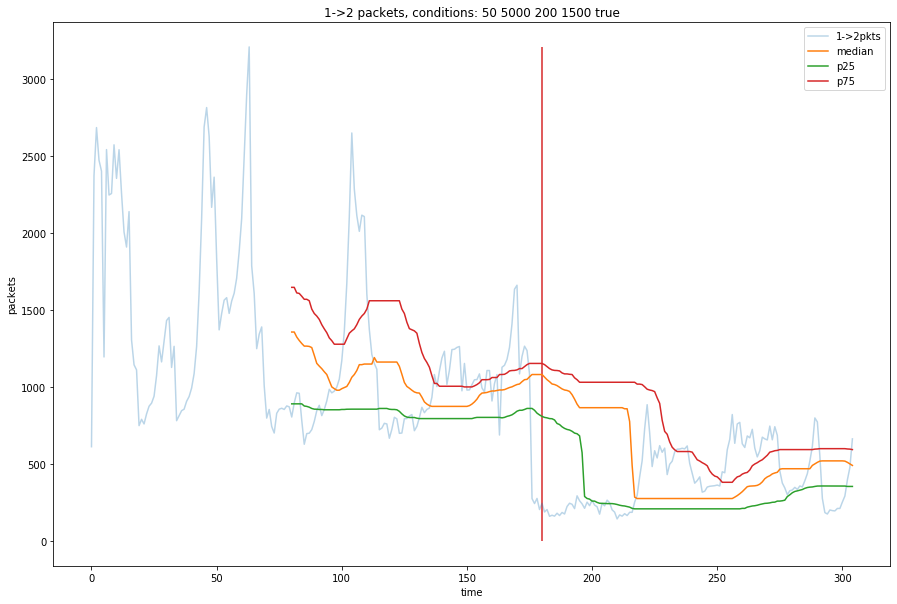

In [68]:
# Median absolute deviation
conditions = '50 5000 200 1500 true'
f = filenames[conditions][0]
f_drop = filenames[conditions][1]
data = pd.read_csv(f)
data_drop = pd.read_csv(f_drop, header=None)
feat = 0

clean = clean_df(data)

X = np.array(clean['1->2Pkts'])
#var = np.vectorize(interpacket_var)(clean['packet_times'])
#X = np.array([X,var]).T
#data_drop.columns = ['drop', 'Time', 'IP1', 'Port1', 'IP2', 'Port2', '?']

stream = pd.DataFrame(np.log(X))

mad = lambda x: np.percentile(np.fabs(x - np.percentile(x, 50)), 60)


window = 80
thresh = 1.5
median = []
p25 = []
p75 = []
lower = []
upper = []
std = []
m = []
maximum = []
stdm = []
stdm2 = []
conv = []
filt = np.flip(np.arange(window)) - window//2
#filt = np.append(np.ones(window//2), -1*np.ones(window-window//2))

for i in range(len(X) - window):
    subset = X[i:i+window]
    median = median + [np.median(subset)]
    p25 = p25 + [np.percentile(subset, 25)]
    p75 = p75 + [np.percentile(subset, 65)]
    lower = lower + [np.median(subset) - thresh*mad(subset)]
    upper = upper + [np.median(subset) + thresh*mad(subset)]
    std = std + [np.std(subset)]
    stdm = stdm + [np.sum((subset-np.median(subset)))/window]
    stdm2 = stdm2 + [np.sum((subset-np.median(subset))**2)/window]
    m = m + [mad(subset)]
    maximum = maximum + [max(subset)]
    conv = conv + [np.dot(subset, filt)/window]
    if i == 150:
        m_210 = np.fabs(subset - np.median(subset))
    
ind = np.arange(len(X)-window) + window
    
plt.plot(X,alpha=0.3, label='1->2pkts')
plt.plot(ind,median, label='median')
plt.plot(ind,p25, label='p25')
plt.plot(ind,p75, label='p75')
#plt.plot(X.index[(len(X)-len(upper)):],upper, label=f'median + {}')
#plt.plot(X.index[(len(X)-len(lower)):],lower)

#plt.plot(X.index[(len(X)-len(std)):],std)
#plt.plot(X.index[(len(X)-len(m)):],m)

plt.vlines(180, 0, max(X), colors='C3')
plt.title(f'1->2 packets, conditions: {conditions}')
plt.ylabel('packets')
plt.xlabel('time')    
plt.legend()

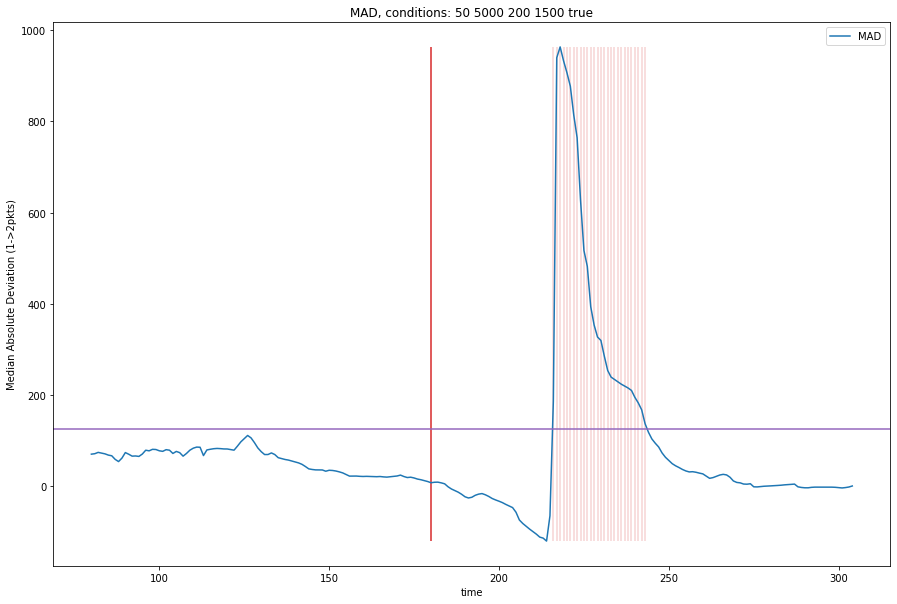

In [69]:
m = np.array(m)
index = ind
da = np.array([m,index]).T

transform = m*stdm / median
thresh = 100 / (window / 100)
mean_t = []
anom = index[(transform > thresh)]

win = 30
for i in range(len(transform) - win):
    mean_t = mean_t + [np.mean(transform[i:i+win])]

plt.plot(index, transform, label='MAD')

plt.vlines(180, min(transform), max(transform), colors='C3')
plt.vlines(anom, min(transform), max(transform), colors='C3', alpha=.2)
plt.axhline(y=thresh, color='C4')
plt.title(f'MAD, conditions: {conditions}')
plt.ylabel('Median Absolute Deviation (1->2pkts)')
plt.xlabel('time')    
plt.legend()

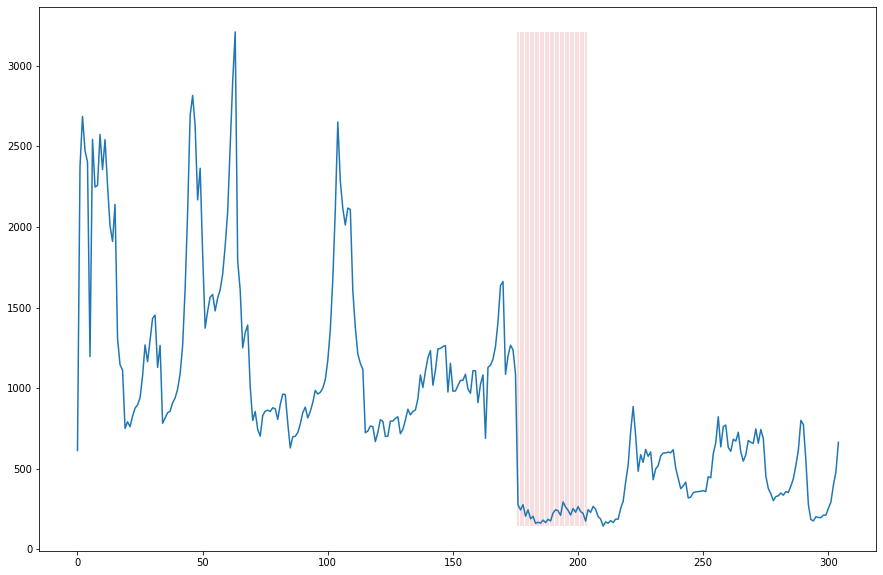

In [70]:
plt.plot(X,alpha=1, label='1->2pkts')
plt.vlines(anom-window//2, min(X), max(X), colors='C3', alpha=.2)

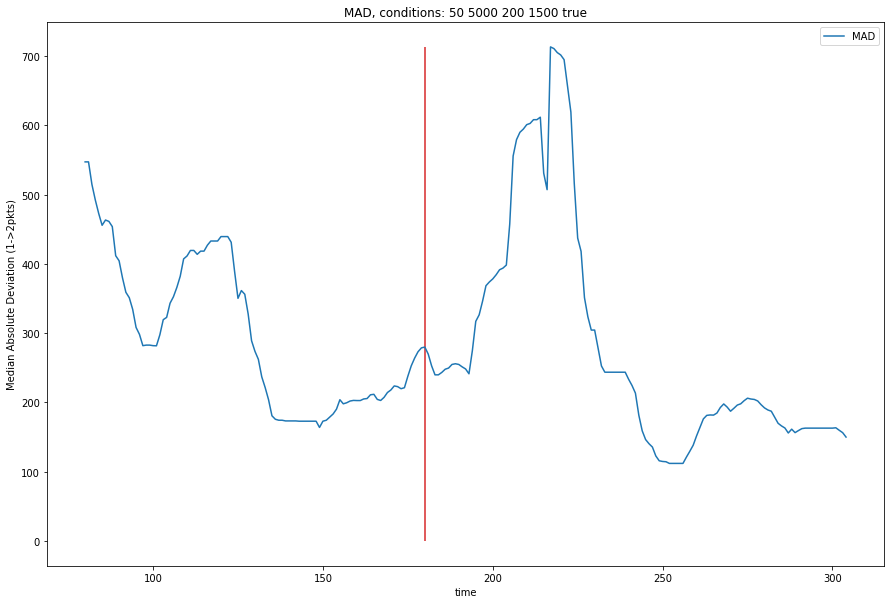

In [71]:
m = np.array(m)
index = ind
da = np.array([m,index]).T

plt.plot(index,m, label='MAD')

plt.vlines(180, 0, max(m), colors='C3')
plt.title(f'MAD, conditions: {conditions}')
plt.ylabel('Median Absolute Deviation (1->2pkts)')
plt.xlabel('time')    
plt.legend()

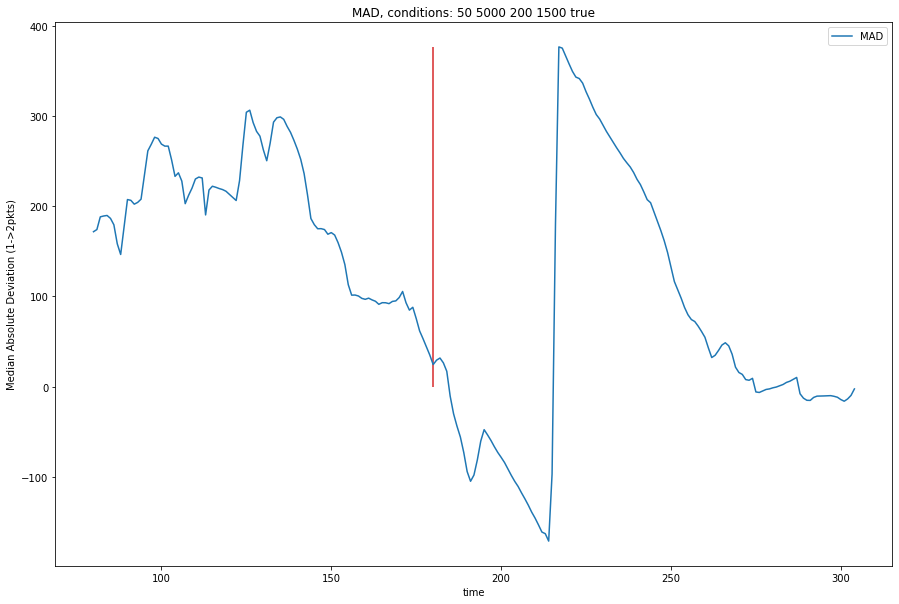

In [72]:
m = np.array(m)
index = ind
da = np.array([m,index]).T

plt.plot(index,stdm, label='MAD')


plt.vlines(180, 0, max(stdm), colors='C3')
plt.title(f'MAD, conditions: {conditions}')
plt.ylabel('Median Absolute Deviation (1->2pkts)')
plt.xlabel('time')    
plt.legend()

In [58]:
'''
the data (x) is a 1 dimentional numpy array of the 1->2 packets
'''
class MAD_model():
    '''
    inputs
    window_size: size of window to shift over
    thresh_height: height of the threshold to detect an anomaly on
    '''
    def __init__(self, window_size, IQR_mult=1.5):
        self.window_size = window_size
        self.IQR_mult = IQR_mult
        self.window = np.zeros(window_size)
        # median, median absolute deviation and deviation from median if needed later
        # for the most recent data passed into rolling_stats
        self.median = None
        self.mad = None
        self.dm = None
    
    '''
    Computes the rolling MAD, Median and average deviation from the median
    returns transform: a function of the 3 stats above
    '''
    def rolling_stats(self, x):
        mad_f = lambda x: np.percentile(np.fabs(x - np.percentile(x, 50)), 60)
        
        median = []
        dm = []
        mad = []
        
        for i in range(len(x)-self.window_size):
            subset = x[i:i+self.window_size]
            m = np.median(subset)
            median = median + [m]
            dm = dm + [np.sum((subset-m))/window]
            mad = mad + [mad_f(subset)]
        
        transform = np.array(mad)*dm / median
        self.median = median
        self.mad = mad
        self.dm = dm
        
        return transform
    
    '''
    detects an anomaly if the function of median, mad and dm are above a certain threshold
    return the indexes of where the anomaly is, already adjusted to the window size
    '''
    def detect_anomaly(self, x):
        transform = self.rolling_stats(x)
        anomaly_index = []
        thresh_l = []
        '''
        index = np.arange(len(transform))
        anomaly_index = index[(transform > self.thresh)] + self.window_size // 2
        '''
        
        for i in np.arange(len(transform) - self.window_size) + self.window_size:
            subset = transform[i:i+self.window_size]
            
            p25 = np.percentile(subset, 25)
            p75 = np.percentile(subset, 75)
            median = np.percentile(subset, 50)
            IQR = p75 - p25
            
            thresh = median + self.IQR_mult * IQR
            thresh_l = thresh_l + [thresh]

            if thresh < transform[i]:
                anomaly_index = anomaly_index + [i]
        
        return np.array(anomaly_index) + self.window_size // 2, thresh_l
    
    '''
    plots the data and anomolous region detected given the data and conditions
    '''
    def plot_region(self, x, conditions, shift_time=None,  filepath=None):
        anom_region, thresh  = self.detect_anomaly(x)
        
        plt.plot(x, label='1->2pkts')
        
        plt.vlines(anom_region, min(x), max(x), colors='C3', alpha=.2)
        
        if shift_time != None:
            plt.vlines(180, 0, max(x), colors='C3')
        
        plt.title(f'1->2 packets, conditions: {conditions}')
        plt.ylabel('packets')
        plt.xlabel('time') 
        plt.legend()
        
        if filepath != None:
            plt.savefig(filepath)

In [75]:
X = np.array(clean['1->2Pkts'])

In [79]:
model = MAD_model(80)
model.detect_anomaly(X)[0]

array([177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
       190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202,
       203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215,
       216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228,
       229, 230, 231, 232, 233, 234, 243, 244, 245, 246, 247])

In [115]:
def arima_model_anomalies(data):
    rmse, model, test, preds,anomalies,upper,lower = eval_arima(np.log(data),(3,0,2),.01,75)
    return anomalies

def MAD_anomalies(data):
    X = np.array(data)
    model = MAD_model(80)
    anomalies_indexes = model.detect_anomaly(X)[0]
    binary_anomaly_list = []
    for i in range(len(data)):
        if i in anomalies_indexes:
            binary_anomaly_list.append(1)
        else:
            binary_anomaly_list.append(0)
            
    return binary_anomaly_list

def anomaly_ensemble(model1, model2, data): 
    preds1 = model1(data)
    preds2 = model2(data)
    
    final_preds = []
    for i in range(75,len(preds1)):
        if (preds1[i]==1 and preds2[i]==1):
            final_preds.append(1)
        else:
            final_preds.append(0)
    
    return final_preds


In [120]:
ma = MAD_anomalies(DF.total_pkts)

In [126]:
anomaly_ensemble(arima_model_anomalies, MAD_anomalies, DF.total_pkts)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [121]:
sum(ma)

3

In [123]:
X = np.array(DF.total_pkts)
model = MAD_model(80)
len(model.detect_anomaly(X)[0])

3

In [125]:
model.detect_anomaly(X)[0]

array([144, 145, 196])